# Task IV - Reduce the Number of Device Statistics to Estimate the Service Metric

## 1. Construct a training set and a test set from the trace as in Task III.

## 2. Optimal Method
- Compute a linear regression model for each of these subsets of the training set
- compute NMAE of each model
- histogram of NMAE
- show the features with the smallest error
- box plot of nmae for all models with 1, 2, ..., 12 features

the smallest NMAE (0.09685993) is the model with features:
['runq-sz', '%%memused', 'cswch/s', 'all_%%usr', 'ldavg-1', 'pgfree/s', 'plist-sz', 'file-nr', 'tps']


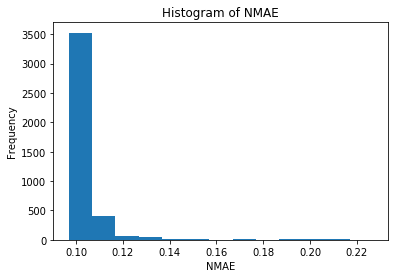

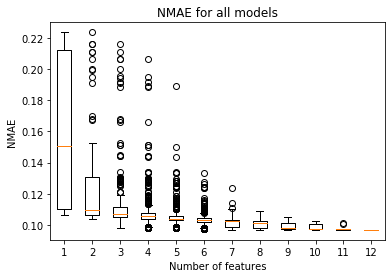

In [59]:
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import time

def subs(l):
    res = []
    for i in range(1, len(l) + 1):
        for combo in itertools.combinations(l, i):
            res.append(list(combo))
    return res

def get_nmae(y_predict, y_test):
    m = len(y_test.index)
    y_mean = y_test['DispFrames'].mean()
    sum_abs_y_mean_predict = 0.0
    i = 0
    for _, row in y_test.iterrows():
        sum_abs_y_mean_predict += abs(row['DispFrames'] - y_predict[i][0])
        i += 1
    
    nmae = (sum_abs_y_mean_predict / m) / y_mean
    return np.round(nmae, decimals=8)

X = pd.read_csv('data/X.csv')
Y = pd.read_csv('data/Y.csv')
Y['TimeStamp'] = Y.TimeStamp.astype(int)
X.index = pd.to_datetime(
    X['TimeStamp'], unit='s')
Y.index = pd.to_datetime(
    Y['TimeStamp'], unit='s')

feature_names = ["runq-sz", "%%memused", "proc/s", "cswch/s", "all_%%usr", 
    "ldavg-1", "totsck", "pgfree/s", 
    "plist-sz", "file-nr", "idel/s", "tps"]

# this is for real
all_subset = subs(feature_names)

# for testing only, so that my computer does not explode
# all_subset = subs(["runq-sz", "%%memused", "proc/s", "cswch/s"])

x_train, x_test, y_train, y_test = train_test_split(X.drop(['TimeStamp'], axis=1), 
        Y[["DispFrames"]], train_size=0.7)

x_train.to_csv("x_train.csv")
x_test.to_csv("x_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

all_nmae = []
nmaes_boxplot_data = []
min_nmaes_each_feature = []
optimal_time = []
for subset in all_subset:
    
    # Compute a linear regression model for each of these subsets of the training set
    regression_model = LinearRegression()
    
    t0 = int(round(time.time() * 1000))
    regression_model.fit(x_train[subset], y_train)
    t1 = int(round(time.time() * 1000))
    
    y_predict = regression_model.predict(x_test[subset])
    
    # compute NMAE of each model
    nmae = get_nmae(y_predict, y_test)
    all_nmae.append(nmae)
    
    if len(nmaes_boxplot_data) < len(subset):
        nmaes_boxplot_data.append([nmae])
    else:
        nmaes_boxplot_data[len(subset) - 1].append(nmae)

    # for instruction number 5
    if len(min_nmaes_each_feature) < len(subset):
        min_nmaes_each_feature.append(nmae)
        optimal_time.append(t1-t0)
    else:
        if nmae < min_nmaes_each_feature[len(subset) - 1]:
            min_nmaes_each_feature[len(subset) - 1] = nmae
            optimal_time[len(subset) - 1] = t1 - t0

# show the features with the smallest error
min_nmae = min(all_nmae)
print("the smallest NMAE ({}) is the model with features:".format(min_nmae))
print(all_subset[all_nmae.index(min_nmae)])

# histogram of NMAE
binwidth = 0.01
plt.hist(all_nmae, 
    bins=np.arange(min(all_nmae), max(all_nmae) + binwidth, binwidth))
plt.xlabel("NMAE")
plt.ylabel("Frequency")
plt.title("Histogram of NMAE")
plt.show()

# box plot of nmae for all models with 1, 2, ..., 12 features
fig7, ax7 = plt.subplots()
ax7.set_title("NMAE for all models")
ax7.set_xlabel("Number of features")
ax7.set_ylabel("NMAE")
ax7.boxplot(nmaes_boxplot_data)
plt.show()

### Analysis

The method which is used to find the features with the smallest error is building a subset of each features, building the linear regression model, then finding the smallest NMAE of all the models built. The features with the smallest error are: 'runq-sz', '%%memused', 'cswch/s', 'all_%%usr', 'idel/s', 'tps'.

From the histogram, we can see the the highest number of error (NMAE) is aronud 0.1 with more than 2500 data. This means that the models mostly have 0.1 error with various features applied to the model.

The boxplot shows the relation between the number of features and the NMAE. The growth of the function resembles the inverse logarithmic function, with the NMAE seems to saturate when the number of features exceeds 4.

## 3. Method 2 (Heuristic method)
- Rank the features according to the square of the correlation values (sort descending order)
- Build twelve feature sets composed of the top k features, k = 1, ..., 12. The first feature set contains the top feature, the second feature set contains the top two features, etc
- compute the linear regression model on the training set and compute the error
- Produce a plot that shows the error value in function of the set size k

Rank of the features according to the square of the correlation values:
plist-sz: 0.6376769572704232
totsck: 0.6348541962392853
runq-sz: 0.6277663322832961
ldavg-1: 0.6168571417878531
cswch/s: 0.5307997934869442
file-nr: 0.5221921171327957
all_%%usr: 0.3093290304770762
%%memused: 0.11959251450970435
idel/s: 0.08221690076956048
proc/s: 0.03640409968203089
pgfree/s: 0.00017554917649260075
tps: 5.284353085283944e-05


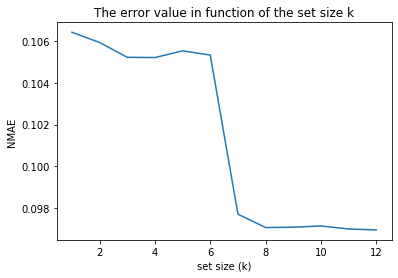

In [60]:
m = len(x_train.index)

correlation_square_map = {}
correlation_map = {}
for feature in feature_names:
    x_mean = x_train[feature].mean()
    y_mean = y_train["DispFrames"].mean()
    x_std = x_train[feature].std()
    y_std = y_train["DispFrames"].std()
    sum_all = 0.0
    
    for idx, xi in x_train.iterrows():
        sum_all += ((xi[feature] - x_mean) * (y_train["DispFrames"][idx])) \
            / (x_std * y_std)
    
    correlation = sum_all / m
    correlation_square_map[feature] = correlation ** 2
    correlation_map[feature] = correlation

# Rank the features according to the square of the correlation values (sort descending order) 
sorted_correlation_sq_tuple = sorted(correlation_square_map.items(), key=lambda kv: kv[1],
    reverse=True)
print("Rank of the features according to the square of the correlation values:")
for item in sorted_correlation_sq_tuple:
    print("{}: {}".format(item[0], item[1]))

all_nmaes = []
heuristic_time = []
for i in range(1, len(sorted_correlation_sq_tuple) + 1):    
    # Build twelve feature sets composed of the top k features
    # compute the linear regression model on the training set and compute the error
    features_to_build = [item[0] for item in sorted_correlation_sq_tuple[0:i]]
    regression_model = LinearRegression()
    
    t0 = int(round(time.time() * 1000))
    regression_model.fit(x_train[features_to_build], y_train)
    t1 = int(round(time.time() * 1000))
    heuristic_time.append(t1 - t0)
    
    y_predict = regression_model.predict(x_test[features_to_build])
    nmae = get_nmae(y_predict, y_test)
    all_nmaes.append(nmae)

# Produce a plot that shows the error value in function of the set size k
plt.plot(range(1, len(all_nmaes) + 1), all_nmaes)
plt.xlabel("set size (k)")
plt.ylabel("NMAE")
plt.title("The error value in function of the set size k")
plt.show()

### Analysis

The correlation values calculated is within the range [-1, +1]. The rank of the correlation values presented is the square of the correlation values, which means all features ranked is positive values. By ranking the square of the correlation values, it is expected to see how each features contribute to the estimated values.

Rank of the features according to the square of the correlation values:
plist-sz
totsck
runq-sz
ldavg-1
cswch/s
file-nr
all_%%usr
%%memused
idel/s
proc/s
tps
pgfree/s

The abosulte correlation value indicates the strength of the relation ship, while the sign of the value shows the direction of the relationship [1].

This heuristic method also shows how many features we need to build such a reliable model in a heuristic way. If the number of features included in a model is less then 6, the NMAE is relatively high. If the number of features is more than 6, the NMAE is steeply reduced. We can say that 8 features is the good number of features to build a model, whereas if we give more than 8, it will not significantly improve the model. The method shows that we need 8 features at least, which are plist-sz, totsck, runq-sz, ldavg-1, cswch/s, file-nr, all_%%usr, %%memused, to build a reliable model.

[1] https://statisticsbyjim.com/basics/correlations/

## 4 Correlation matrix showing the correlation between variables

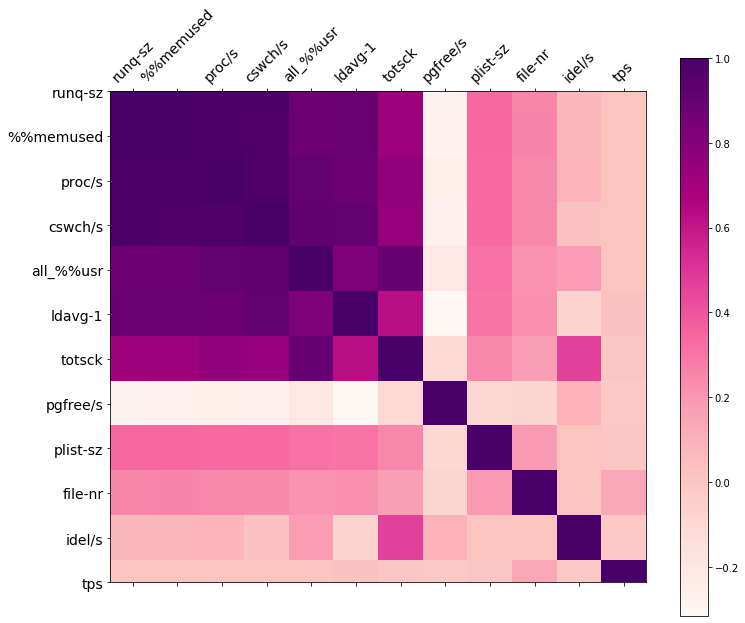

In [61]:
sorted_feature = [key for key, value in sorted_correlation_sq_tuple]
x_train_sorted = x_train[sorted_feature]
f = plt.figure(figsize=(12, 10))
plt.matshow(x_train_sorted.corr(), fignum=f.number, cmap='RdPu')
plt.xticks(range(len(x_train.columns)), x_train.columns, fontsize=14, rotation=45)
plt.yticks(range(len(x_train.columns)), x_train.columns, fontsize=14)
plt.colorbar()
plt.show()

### Analysis

According to the optimal method (part 2), the smallest NMAE is given by a model built with 6 features: 'runq-sz', '%%memused', 'cswch/s', 'all_%%usr', 'idel/s', 'tps'. These 6 features has correlation values of:
- runq-sz: -0.78806
- cswch/s: -0.73018
- all_%%usr: -0.55778
- %%memused: 0.34898
- idel/s: -0.25513
- tps: 0.0001977

As we discussed, the absolute value of the correlation shows the strength while the sign gives the direction. The feature `run-qz`, `cswch/s`, and `all_%%usr` have high correlation values and affect the target in negative relationship. While those features highly affect the model, the `tps` feature has very small correlation value, which means it does not really affect the result of the model calculation.

The heuristic method in part 3 selects the features based on the ranking of the squared correlation values (we can also easily infer that this means the absolute values that we are considering). This method tries to find the best model built for each k features by choosing the most correlated features.

## 5. Compare the optimal method with the heuristic method

- A single plot with two curves: The vertical axis is NMAE and horizontal axis is the size k of the feature set.
  - The first curve shows the minimum error of the optimal method for feature sets of size k
  - The second curve shows the error of heuristic method for the sets with the top k features

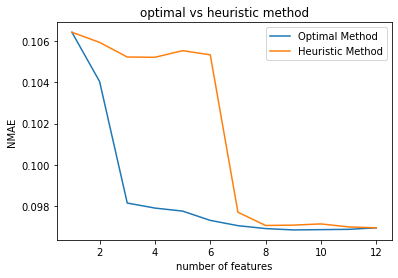

[0.10641443, 0.10403296, 0.09815904, 0.09791591, 0.09776953, 0.09732086, 0.0970656, 0.09692486, 0.09685993, 0.09687329, 0.09688764, 0.09696111]
[2, 2, 2, 2, 3, 2, 8, 2, 2, 2, 3, 3]
---
[0.10641443, 0.10592443, 0.10521689, 0.10520312, 0.10552432, 0.10532269, 0.09771442, 0.09707446, 0.09709065, 0.09714997, 0.09700545, 0.09696111]
[3, 2, 2, 3, 8, 9, 3, 3, 3, 4, 11, 3]


In [62]:
plt.plot(range(1, len(min_nmaes_each_feature) + 1), min_nmaes_each_feature, label='Optimal Method')
plt.plot(range(1, len(min_nmaes_each_feature) + 1), 
    all_nmaes[0:len(min_nmaes_each_feature)], label='Heuristic Method')
plt.legend()
plt.xlabel("number of features")
plt.ylabel("NMAE")
plt.title("optimal vs heuristic method")
plt.show()

# for optional task
print(min_nmaes_each_feature)
print(optimal_time)
print("---")
print(all_nmaes)
print(heuristic_time)

### Analysis

#### Comparison of  the two curves and the difference in error values explanation

The curves show the relationship between the number of features and the error values. For every model built with 1 to 11 features, the error of optimal method is smaller than those of heuristic method. This means that optimal method gives more precise model than the heuristic model, which is expected. Heuristic focuses more on reaching immediate goal yet not guaranteed to be optimal or perfect [2].

Another thing to see from the graph is when the model generates smaller errors. With the optimal method, even with only 4 features, it can build a model with smaller errors. In heuristic method, only models with more than 6 features has smaller error values.

The optimal method tries to find the most correlated features by brute forcing, creating different models with all combinations of all features. This is very exhausting task yet guaranteed to find the best model. On the other hand, heuristic model tries to calculate the correlation value and determine what features it will take based on the result of the correlation values calculation.

#### Conclusion

- The optimal method is slower, with the growth function of O(2^n), while heuristic method is faster, with the growth function of O(n)
- The optimal method is more accurate than the heuristic method to find the most correlated features to build the model
- If the number of features are relatively small, than optimal method can be used. If the number of features are high, then heuristic method is preferable. However, the trade-offs between accuracy and efficiency must be taken into account.

[2] https://en.wikipedia.org/wiki/Heuristic